In [1]:
save_figures = False

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['legend.handlelength'] = 1

In [4]:
from kid_readout.measurement import core
from kid_readout.measurement.io import nc
from kid_readout.analysis.timeseries import binning

In [5]:
nc_files = ['/data/readout/2016-07-13_104209_magnetic_shield.nc',  # shield
            '/data/readout/2016-07-13_160639_ambient.nc',  # ambient
            '/data/readout/2016-07-14_125121_magnet_array.nc',  # 162 mm, up
            '/data/readout/2016-07-14_191847_magnet_array.nc',  # 65 mm, up
            '/data/readout/2016-07-15_001146_magnet_array.nc',  # 100 mm, up
            '/data/readout/2016-07-15_123235_magnet_array.nc',  # 120 mm, up
            '/data/readout/2016-07-15_165543_magnet_array.nc',  # 140 mm, up
            '/data/readout/2016-07-16_140542_magnet_array.nc',  # 150 mm, up
            '/data/readout/2016-07-18_135051_magnet_array.nc',  # 85 mm, up
            '/data/readout/2016-07-18_184047_magnet_array.nc',  # 130 mm, up; saved as 85 mm and retroactively fixed
            '/data/readout/2016-07-19_143115_magnet_array.nc',  # 145 mm, up
            '/data/readout/2016-07-19_200237_magnet_array.nc',  # 155 mm, up
            '/data/readout/2016-07-22_130630_magnet_array.nc',  # 65 mm, down
            '/data/readout/2016-07-22_173850_magnet_array.nc',  # 0 mm, up
            #'/data/readout/2016-07-25_143431_magnet_array.nc'   # 0 mm, recorded as down but actually up
            '/data/readout/2016-07-26_111004_magnet_array.nc',  # 0 mm, down
            ]

In [6]:
names = ['SweepStreamArray8'] + (len(nc_files) - 1) * ['SweepStreamArray13']
dfs = []

for nc_file, name in zip(nc_files, names):
    print(nc_file)
    ncf = nc.NCFile(nc_file)
    ssa = ncf.read(name)
    if nc_file == '/data/readout/2016-07-18_184047_magnet_array.nc': 
        assert ssa.state.magnet_array.height_mm == 130
        #ssa.state.magnet_array.height_mm = 130
    # This is a hack: only the full stream array state is currently processed
    #ssa.stream_array.state = ssa.state
    dfs.append(ssa.to_dataframe())
    ncf.close()

/data/readout/2016-07-13_104209_magnetic_shield.nc
/data/readout/2016-07-13_160639_ambient.nc
/data/readout/2016-07-14_125121_magnet_array.nc
/data/readout/2016-07-14_191847_magnet_array.nc
/data/readout/2016-07-15_001146_magnet_array.nc
/data/readout/2016-07-15_123235_magnet_array.nc
/data/readout/2016-07-15_165543_magnet_array.nc
/data/readout/2016-07-16_140542_magnet_array.nc
/data/readout/2016-07-18_135051_magnet_array.nc
/data/readout/2016-07-18_184047_magnet_array.nc
/data/readout/2016-07-19_143115_magnet_array.nc
/data/readout/2016-07-19_200237_magnet_array.nc
/data/readout/2016-07-22_130630_magnet_array.nc
/data/readout/2016-07-22_173850_magnet_array.nc
/data/readout/2016-07-26_111004_magnet_array.nc


In [7]:
up_offset = 8.6198539821769611
up_slope = 450592601.5250684
down_offset = -7.675890008999394
down_slope = -452796357.53515184

def magnet_field_uT(d_mm, orientation):
    B = np.zeros_like(d_mm)
    B[orientation == -1] = down_slope / d_mm[orientation == -1]**3 + down_offset
    B[orientation == 1] = up_slope / d_mm[orientation == 1]**3 + up_offset
    return B

def peak_indices(x, y, number, x_min=-np.inf, x_max=np.inf):
    min_index = np.argmin(np.abs(x - x_min))
    max_index = np.argmax(np.abs(x - x_max)) + 1
    unshifted = y[min_index:max_index].argsort()[-number:]
    shifted = unshifted + min_index
    return shifted

In [8]:
for index, d in enumerate(dfs):
    d['shield'] = index == 0

for index, d in enumerate(dfs):
    d['ambient'] = index == 1

# The early data, with magnet field up, didn't include the magnet orientation;
# The later data, including that with the field down, did.
for d in dfs:
    if 'magnet_array_orientation' not in d.columns:
        if np.all(d.shield) or np.all(d.ambient):
            d['magnet_array_orientation'] = 0
        else:
            d['magnet_array_orientation'] = 1

In [9]:
df = pd.concat(dfs)

df['optical_plate_to_stage_top_mm'] = 335
df['stage_top_to_chip_mm'] = 4.82
df['jack_top_to_magnet_center_mm'] = 25.5 + 1.5
df['magnet_distance_mm'] = (df.optical_plate_to_stage_top_mm + df.stage_top_to_chip_mm -
                            (df.magnet_array_height_mm + df.jack_top_to_magnet_center_mm))

df['magnet_field_uT'] = magnet_field_uT(np.array(df.magnet_distance_mm), np.array(df.magnet_array_orientation))
df['ambient_field_uT'] = -30
df.loc[df.shield, 'ambient_field_uT'] = 0
df['field_uT'] = df.ambient_field_uT + df.magnet_field_uT

In [10]:
df.shape

(60, 70)

In [11]:
shield_color = 'gray'
shield_linestyle = '--'

ambient_color = 'green'
ambient_linestyle = '-'

array_color = 'blue'

mappable_B = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=df.field_uT.min(), vmax=df.field_uT.max()),
                                   cmap=plt.cm.coolwarm)

# Sweeps

In [12]:
def plot_resonances_from_original(dataframe, axis, f_scale=1e-6, normalize=False, **plot_kwds):
    for n, row in dataframe.iterrows():
        sss = core.from_series(row)
        frequency = f_scale * sss.sweep.frequency
        if normalize:
            data = sss.sweep.s21_normalized
        else:
            data = sss.sweep.s21_point
        axis.plot(frequency,
                  20 * np.log10(np.abs(data)),
                  color=mappable_B.to_rgba(row.field_uT), **plot_kwds)

def plot_resonances(dataframe, axis, f_scale=1e-6, normalize=False,
                    plot_data=True, plot_model=True, plot_resonance=True,
                    data_marker='o', data_markersize=1, resonance_marker='s', resonance_markersize=2,
                    **plot_kwds):
    for n, row in dataframe.iterrows():
        if plot_data:
            if normalize:
                ax.plot(f_scale * row.res_frequency_data,
                        20 * np.log10(np.abs(row.res_s21_data_normalized)),
                        color=mappable_B.to_rgba(row.field_uT),
                        linestyle='none', marker=data_marker, markersize=data_markersize, **plot_kwds)
            else:
                ax.plot(f_scale * row.res_frequency_data,
                        20 * np.log10(np.abs(row.res_s21_data)),
                        color=mappable_B.to_rgba(row.field_uT),
                        linestyle='none', marker=data_marker, markersize=data_markersize, **plot_kwds)
        if plot_model:
            if normalize:
                ax.plot(f_scale * row.res_model_frequency,
                        20 * np.log10(np.abs(row.res_model_s21_normalized)),
                        color=mappable_B.to_rgba(row.field_uT),
                        linestyle='-', **plot_kwds)
            else:
                ax.plot(f_scale * row.res_model_frequency,
                        20 * np.log10(np.abs(row.res_model_s21)),
                        color=mappable_B.to_rgba(row.field_uT),
                        linestyle='-', **plot_kwds)

        

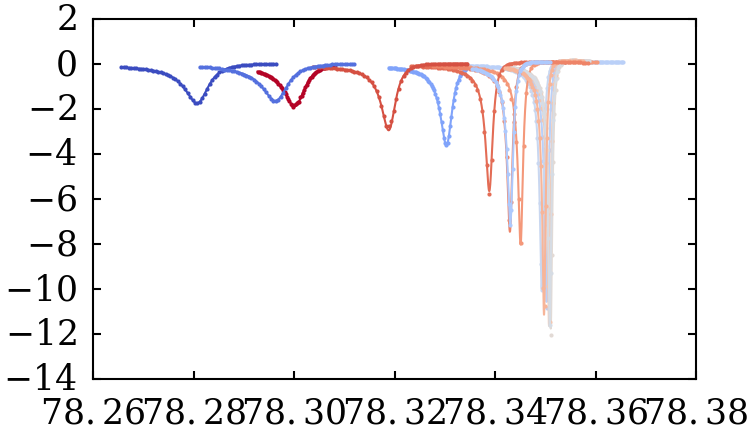

In [13]:
number = 0
attenuation = 41
dfn = df[(df.number == number) & (df.roach_dac_attenuation==attenuation)]

fig, ax = plt.subplots()
plot_resonances(dataframe=dfn, axis=ax, normalize=True, plot_data=True)

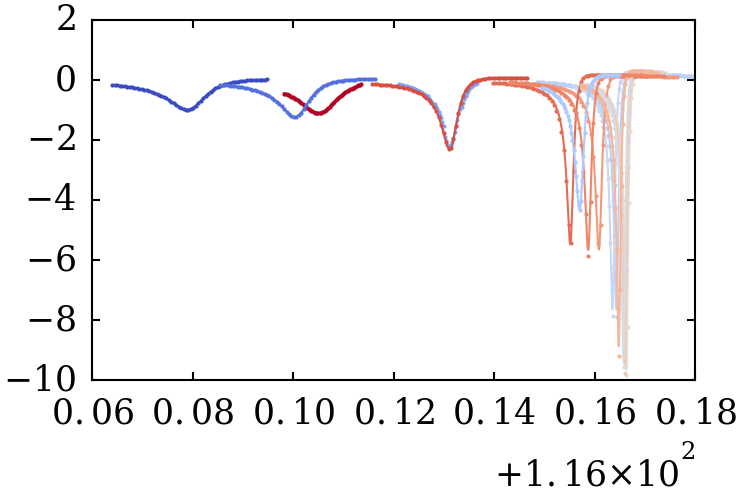

In [14]:
number = 1
attenuation = 41
dfn = df[(df.number == number) & (df.roach_dac_attenuation==attenuation)]

fig, ax = plt.subplots()
plot_resonances(dataframe=dfn, axis=ax, normalize=True, plot_data=True)

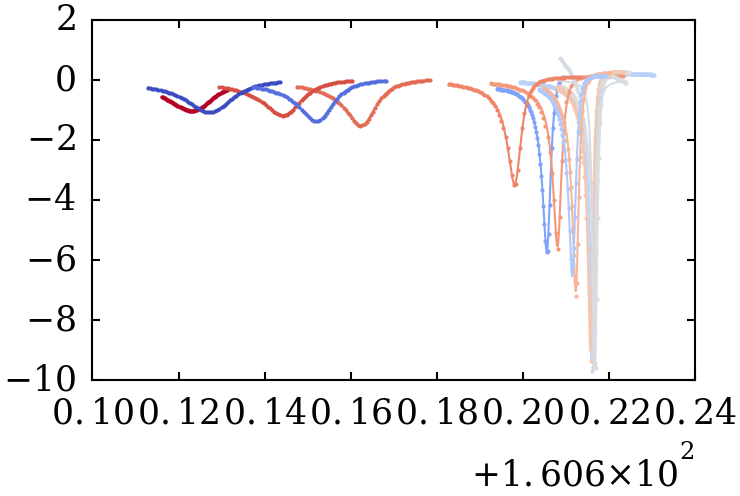

In [15]:
number = 2
attenuation = 41
dfn = df[(df.number == number) & (df.roach_dac_attenuation==attenuation)]

fig, ax = plt.subplots()
plot_resonances(dataframe=dfn, axis=ax, normalize=True, plot_data=True)

# $Q_i$ vs $d$

In [16]:
def plot_Qi_vs_d(dfn):
    fig, ax = plt.subplots()
    ax.set_xlabel('magnet distance / mm')
    ax.set_ylabel('$Q_i \; / \; 10^5$')
    ax.set_title('{:.1f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))
    ax.axhline(dfn[dfn.shield].iloc[0].res_Q_i / 1e5, linestyle=shield_linestyle, color=shield_color)
    ax.axhline(dfn[dfn.ambient].iloc[0].res_Q_i / 1e5, linestyle=ambient_linestyle, color=ambient_color)
    ax.plot(dfn.magnet_distance_mm,
            dfn.res_Q_i / 1e5,
            marker='o', linestyle='none', color=array_color)
    ax.set_ylim(0, 3.5);
    return fig, ax

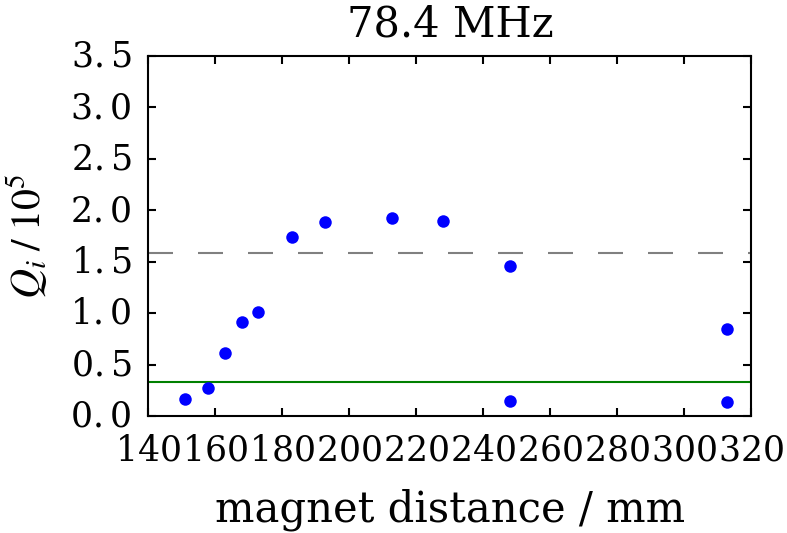

In [17]:
number = 0
fig, ax = plot_Qi_vs_d(dfn=df[df.number == number])
if save_figures:
    fig.savefig('2016-07-20_Qi_vs_distance_preliminary_{}.pdf'.format(number))

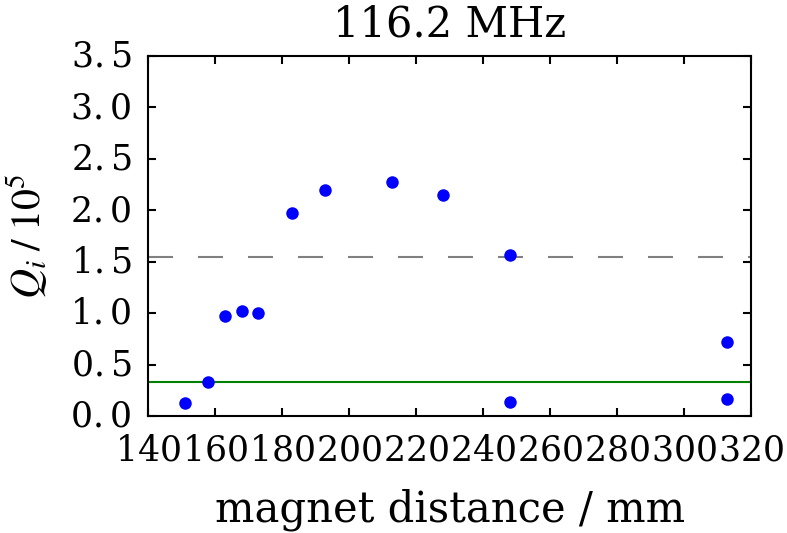

In [18]:
number = 1
fig, ax = plot_Qi_vs_d(dfn=df[df.number == number])
if save_figures:
    fig.savefig('2016-07-20_Qi_vs_distance_preliminary_{}.pdf'.format(number))

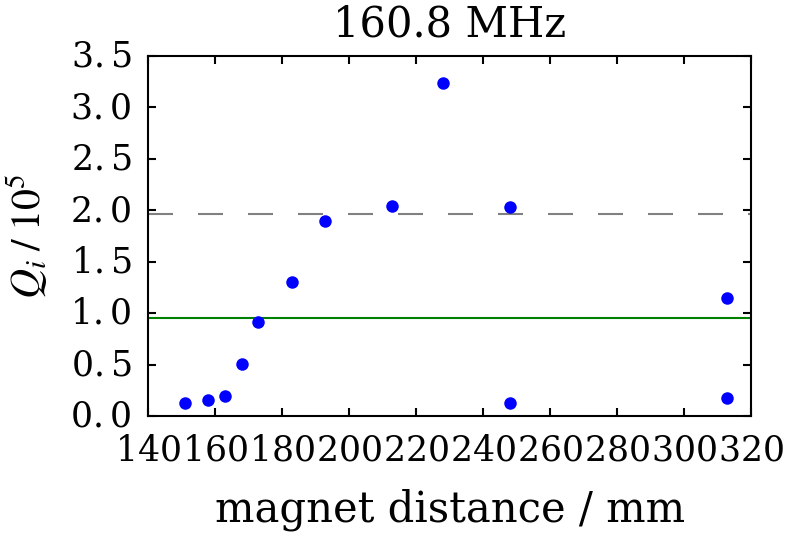

In [19]:
number = 2
fig, ax = plot_Qi_vs_d(dfn=df[df.number == number])
if save_figures:
    fig.savefig('2016-07-20_Qi_vs_distance_preliminary_{}.pdf'.format(number))

# $1 / Q_i$ versus $B$

In [20]:
def plot_iQi_vs_B(dfn):
    fig, ax = plt.subplots()
    ax.set_xlabel('magnetic field $B \; / \; \mu$T')
    ax.set_ylabel('$10^6 \; Q_i^{-1}$')
    ax.set_title('{:.1f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))
    ax.plot(dfn[dfn.shield].iloc[0].field_uT,
            1e6 / dfn[dfn.shield].iloc[0].res_Q_i,
            marker='o', linestyle='none', color=shield_color, label='shield')
    ax.plot(dfn[dfn.ambient].iloc[0].field_uT,
            1e6 / dfn[dfn.ambient].iloc[0].res_Q_i,
            marker='o', linestyle='none', color=ambient_color, label='ambient')
    array_mask = np.array(dfn.magnet_array_orientation, dtype=np.bool)
    ax.plot(dfn[array_mask].field_uT,
            1e6 / dfn[array_mask].res_Q_i,
            marker='o', linestyle='none', color=array_color, label='array')
    ax.set_ylim(0, 85)
    ax.set_xlim(-150, 150)
    ax.legend(loc='lower left', numpoints=1)
    return fig, ax

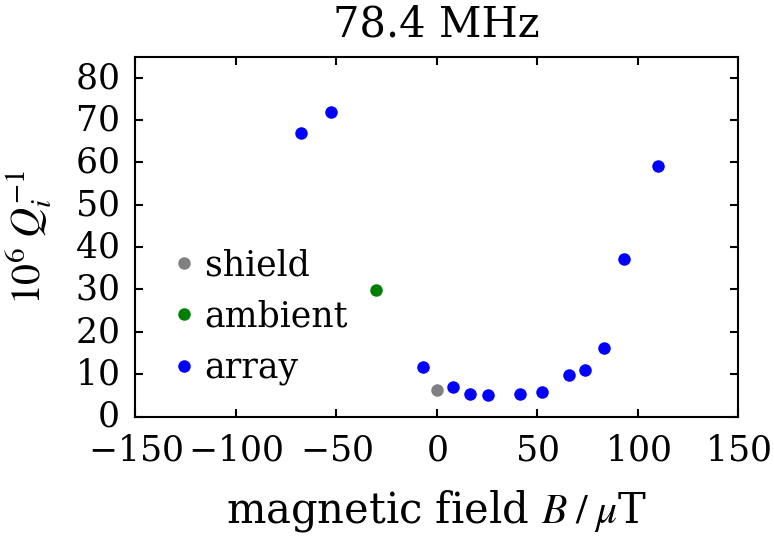

In [21]:
number = 0
fig, ax = plot_iQi_vs_B(dfn=df[df.number == number])
if save_figures:
    fig.savefig('2016-07-20_iQi_vs_net_field_preliminary_{}.pdf'.format(number))

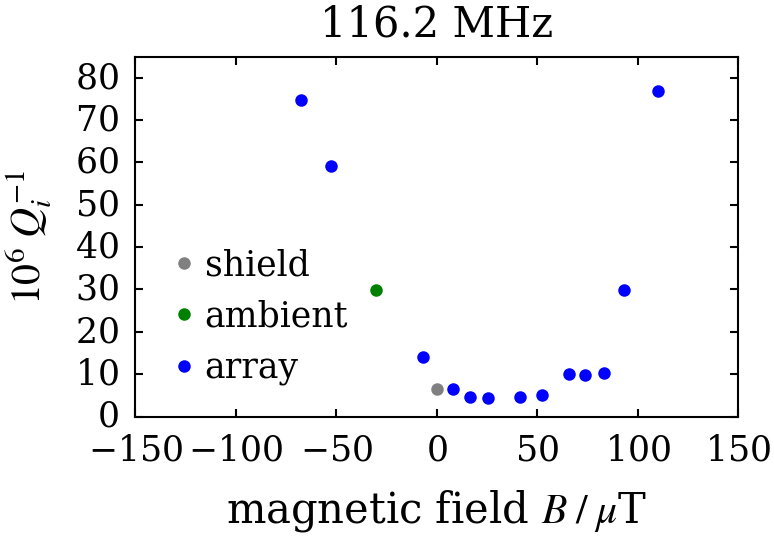

In [22]:
number = 1
fig, ax = plot_iQi_vs_B(dfn=df[df.number == number])
if save_figures:
    fig.savefig('2016-07-20_iQi_vs_net_field_preliminary_{}.pdf'.format(number))

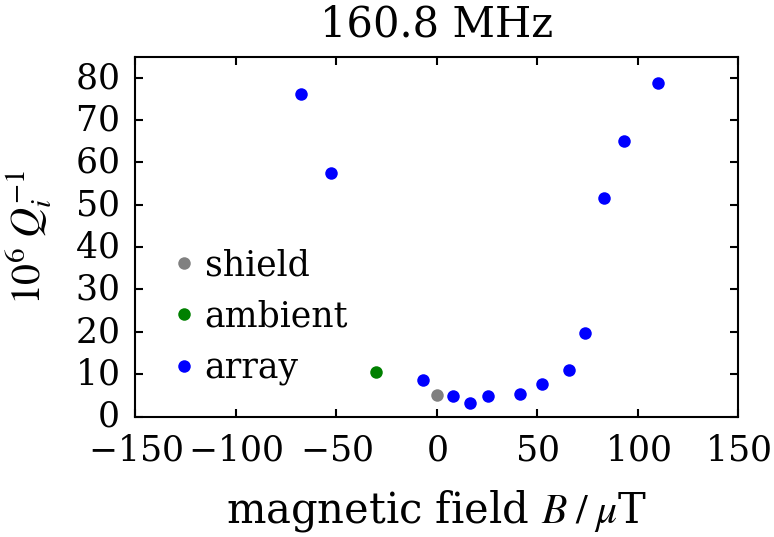

In [23]:
number = 2
fig, ax = plot_iQi_vs_B(dfn=df[df.number == number])
if save_figures:
    fig.savefig('2016-07-20_iQi_vs_net_field_preliminary_{}.pdf'.format(number))

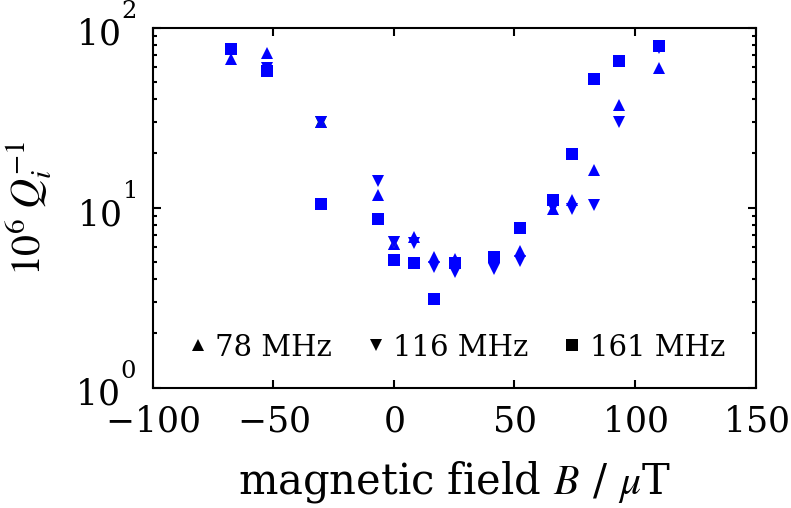

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel('magnetic field $B$ / $\mu$T')
ax.set_ylabel('$10^6 \; Q_i^{-1}$')
ax.set_yscale('log')
markers = ['^', 'v', 's']

handles = []

for number, marker in enumerate(markers):
    dfn = df[df.number == number]
    ax.plot(0,
            1e6 / dfn[dfn.shield].iloc[0].res_Q_i,
            marker=marker, linestyle='none', color=shield_color)
    ax.plot(dfn[dfn.ambient].iloc[0].ambient_field_uT,
            1e6 / dfn[dfn.ambient].iloc[0].res_Q_i,
            marker=marker, linestyle='none', color=ambient_color)
    ax.plot(dfn.field_uT,
            1e6 / dfn.res_Q_i,
            marker=marker, linestyle='none', color=array_color)
    handles.append(mpl.lines.Line2D([], [], color='black', marker=marker, linestyle='none',
                                    markersize=3, label="{:.0f} MHz".format(1e-6 * dfn[dfn.shield].iloc[0].res_f_0)))

plt.legend(handles=handles, loc='lower center', ncol=3, fontsize=7, numpoints=1);
#ax.set_xlim(-130, 130);

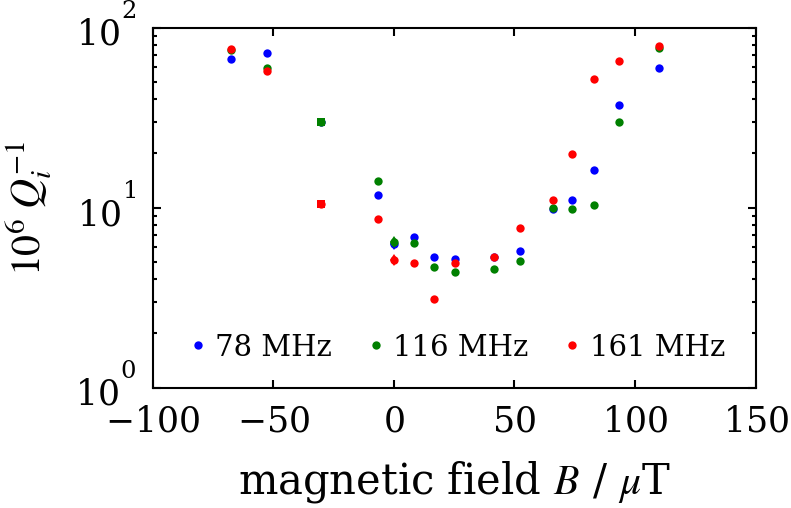

In [25]:
array_marker = 'o'
ambient_marker = 's'
shield_marker = 'd'
markersize = 2
colors = ['blue', 'green', 'red']
alpha = 1

fig, ax = plt.subplots()
ax.set_xlabel('magnetic field $B$ / $\mu$T')
ax.set_ylabel('$10^6 \; Q_i^{-1}$')
ax.set_yscale('log')

for number, color in enumerate(colors):
    dfn = df[df.number == number]
    ax.plot(0,
            1e6 / dfn[dfn.shield].iloc[0].res_Q_i,
            marker=shield_marker, markersize=markersize, linestyle='none', color=color, alpha=alpha)
    ax.plot(dfn[dfn.ambient].iloc[0].ambient_field_uT,
            1e6 / dfn[dfn.ambient].iloc[0].res_Q_i,
            marker=ambient_marker, markersize=markersize, linestyle='none', color=color, alpha=alpha)
    ax.plot(dfn.field_uT,
            1e6 / dfn.res_Q_i,
            marker=array_marker, markersize=markersize, linestyle='none', color=color, alpha=alpha,
            label='{:.0f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))

ax.legend(loc='lower center', ncol=3, fontsize=7, numpoints=1);

if save_figures:
    fig.savefig('2016-08-01_iQi_vs_B_three_resonators_preliminary.pdf')

# Noise

number = 0

dfn = df[df.number == number]
mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=dfn.field_uT.min(), vmax=dfn.field_uT.max()),
                                 cmap=plt.cm.coolwarm)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_{xx} \; [\mathrm{Hz}^{-1}]$')
ax.set_title('{:.1f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))

ax.plot(dfn[dfn.shield].iloc[0].S_frequency,
        dfn[dfn.shield].iloc[0].S_xx,
        linestyle=shield_linestyle, color=shield_color, label='shield')

ax.plot(dfn[dfn.ambient].iloc[0].S_frequency,
        dfn[dfn.ambient].iloc[0].S_xx,
        linestyle=ambient_linestyle, color=ambient_color, label='ambient')

for index, row in dfn[dfn.net_field_uT.notnull()].iterrows():
    ax.plot(row.S_frequency,
            row.S_xx,
            color=mappable.to_rgba(row.field_uT))

ax.legend(loc='best', fontsize='xx-small')
mappable.set_array(np.array(dfn[dfn.field_uT.notnull()].field_uT))
fig.colorbar(mappable, label='$B \; [\mu \mathrm{T}]$');

if save_figures:
    fig.savefig('2016-07-18_B_vs_Sxx_preliminary_{}.pdf'.format(number))

# $S_{xx} - S_{yy}$

In [29]:
def plot_Sxx_minus_Syy(dfn):
    mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=dfn.field_uT.min(), vmax=dfn.field_uT.max()),
                                     cmap=plt.cm.coolwarm)
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$|S_{xx} - S_{yy}| \; [\mathrm{Hz}^{-1}]$')
    ax.set_title('{:.1f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))

    ax.plot(dfn[dfn.shield].iloc[0].S_frequency,
            np.abs(dfn[dfn.shield].iloc[0].S_xx - dfn[dfn.shield].iloc[0].S_yy),
            linestyle=shield_linestyle, color=shield_color, label='shield')

    ax.plot(dfn[dfn.ambient].iloc[0].S_frequency,
            np.abs(dfn[dfn.ambient].iloc[0].S_xx - dfn[dfn.ambient].iloc[0].S_yy),
            linestyle=ambient_linestyle, color=ambient_color, label='ambient')

    for index, row in dfn[dfn.field_uT.notnull()].iterrows():
        ax.plot(row.S_frequency,
                np.abs(row.S_xx - row.S_yy),
                color=mappable.to_rgba(row.field_uT))

    ax.legend(loc='best', fontsize='xx-small')
    mappable.set_array(np.array(dfn[dfn.field_uT.notnull()].field_uT))
    fig.colorbar(mappable, label='$B \; [\mu \mathrm{T}]$');
    return fig, ax

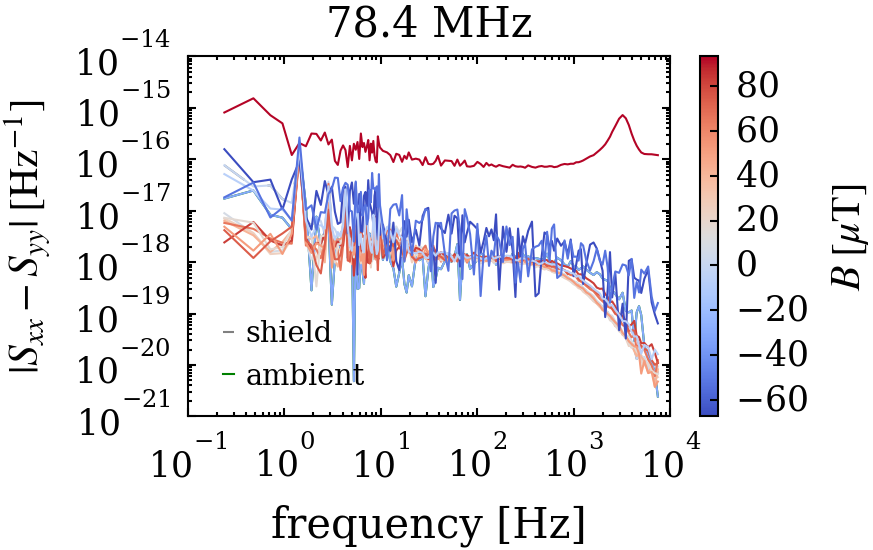

In [30]:
number = 0
fig, ax = plot_Sxx_minus_Syy(df[(df.number==number) & (df.field_uT.isnull() | (df.field_uT < 100))])
if save_figures:
    fig.savefig('2016-07-18_net_field_vs_Sxx-Syy_preliminary_{}.pdf'.format(number))

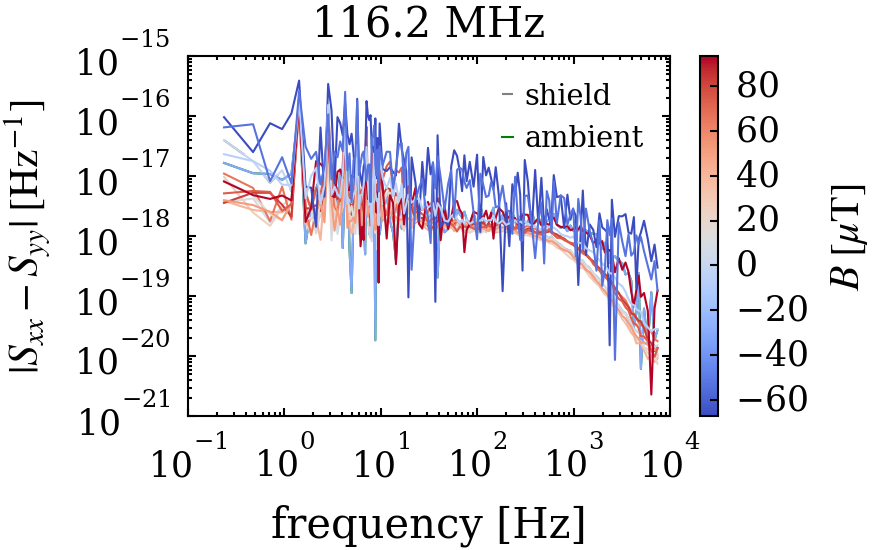

In [32]:
number = 1
fig, ax = plot_Sxx_minus_Syy(df[(df.number==number) & (df.field_uT.isnull() | (df.field_uT < 100))])
if save_figures:
    fig.savefig('2016-07-18_net_field_vs_Sxx-Syy_preliminary_{}.pdf'.format(number))

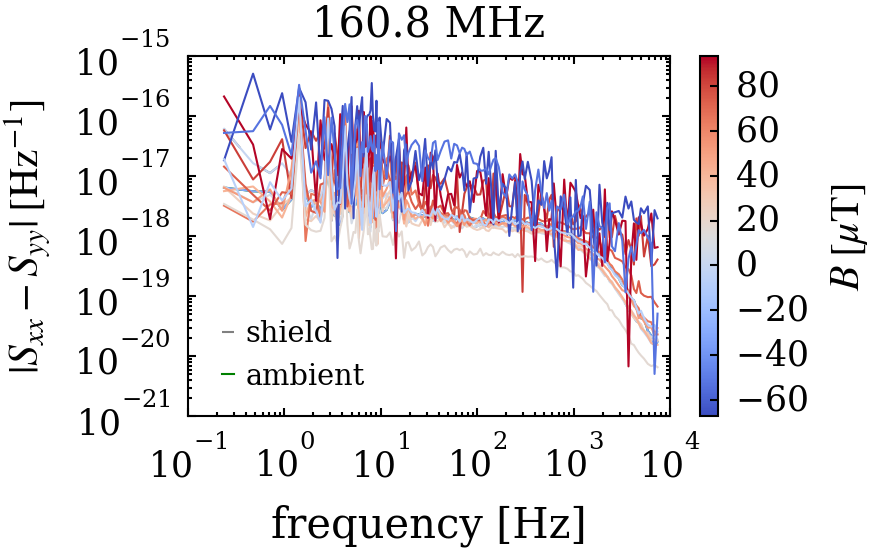

In [33]:
number = 2
fig, ax = plot_Sxx_minus_Syy(df[(df.number==number) & (df.field_uT.isnull() | (df.field_uT < 100))])
if save_figures:
    fig.savefig('2016-07-18_net_field_vs_Sxx-Syy_preliminary_{}.pdf'.format(number))

# Unbinned, full-resolution noise

In [34]:
shield = nc.NCFile(nc_files[0]).read(names[0])

In [35]:
ss = shield[2]

In [36]:
ss.set_S(detrend=plt.mlab.detrend_none, window=plt.mlab.window_hanning, binned=False, NFFT=ss.stream.s21_raw.size)

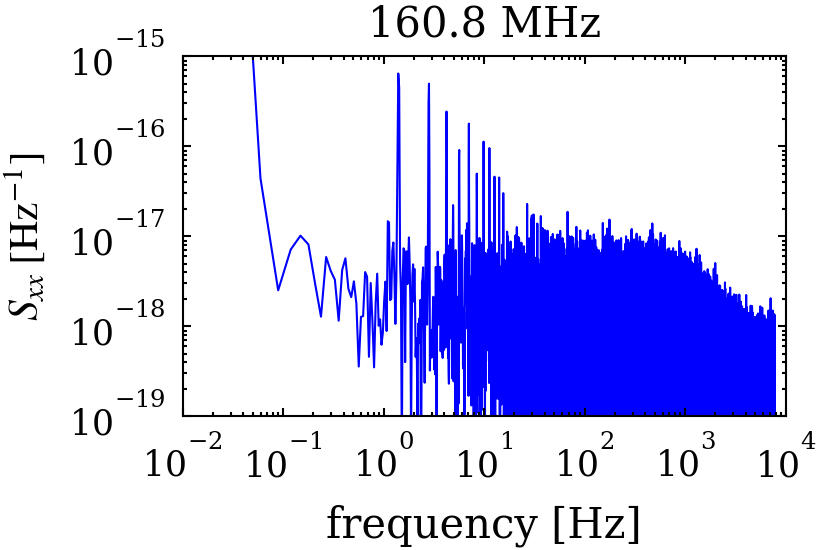

In [37]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_{xx} \; [\mathrm{Hz}^{-1}]$')
ax.set_title('{:.1f} MHz'.format(1e-6 * ss.sweep.resonator.f_0))
ax.plot(ss.S_frequency, ss.S_xx)
ax.set_ylim(1e-19, 1e-15);

if save_figures:
    fig.savefig('2016-07-18_full-resolution_unbinned_Sxx.pdf')

# Masking pulse tube harmonics

In [38]:
pi = peak_indices(x=ss.S_frequency, y=ss.S_xx, number=18, x_min=1, x_max=1e2)
#f_ptc = ss.S_frequency[pi][ss.S_frequency[pi].argsort()[0:2]].mean()
f_ptc = 1.412

print("PTC frequency {:.3f} Hz".format(f_ptc))
print("Harmonics: " + ', '.join(["{:.2f}".format(f) for f in sorted(ss.S_frequency[pi] / f_ptc)]))

PTC frequency 1.412 Hz
Harmonics: 0.97, 0.99, 1.01, 1.98, 2.01, 2.03, 2.98, 3.00, 3.02, 3.99, 4.01, 4.98, 5.00, 5.99, 6.99, 7.01, 8.00, 8.99


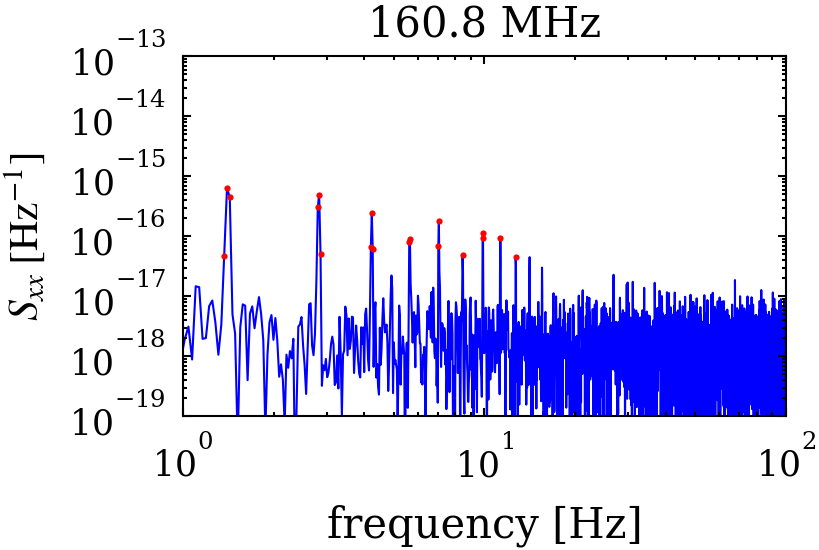

In [39]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_{xx} \; [\mathrm{Hz}^{-1}]$')
ax.set_title('{:.1f} MHz'.format(1e-6 * ss.sweep.resonator.f_0))
ax.plot(ss.S_frequency, ss.S_xx)
ax.plot(ss.S_frequency[pi], ss.S_xx[pi], '.r')
ax.set_ylim(1e-19, 1e-13)
ax.set_xlim(1, 100);

if save_figures:
    fig.savefig('2016-07-18_full-resolution_unbinned_Sxx.pdf')

In [40]:
mask = np.ones_like(ss.S_frequency, dtype=np.bool)
mask[pi] = False
S_frequency_masked = ss.S_frequency[mask]
S_xx_masked = ss.S_xx[mask]
log_bin_edges = binning.log_bin_edges(S_frequency_masked, bins_per_decade=30, ensure_none_empty=False)
bin_indices = np.digitize(S_frequency_masked, log_bin_edges)
S_frequency_binned = np.array([S_frequency_masked[bin_indices==n].mean() for n in range(1, bin_indices.size)])
S_xx_binned = np.array([S_xx_masked[bin_indices==n].mean() for n in range(1, bin_indices.size)])

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


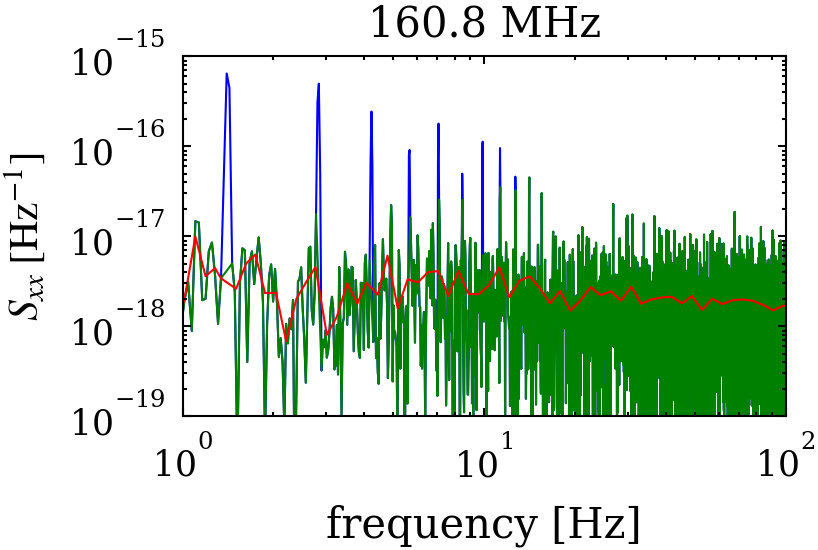

In [41]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_{xx} \; [\mathrm{Hz}^{-1}]$')
ax.set_title('{:.1f} MHz'.format(1e-6 * ss.sweep.resonator.f_0))
ax.plot(ss.S_frequency, ss.S_xx)
ax.plot(S_frequency_masked, S_xx_masked, 'g')
ax.plot(S_frequency_binned, S_xx_binned, 'r')
ax.set_ylim(1e-19, 1e-15)

if save_figures:
    fig.savefig('2016-07-19_Sxx_full-resolution_raw_notched_binned_Hann.png')
ax.set_xlim(1, 100);
if save_figures:
    fig.savefig('2016-07-19_Sxx_full-resolution_raw_notched_binned_detail_Hann.png')

In [42]:
def harmonic_mask(f, fundamental, num_harmonics, width):
    mask = np.ones(f.size, dtype=np.bool)
    for harmonic in range(1, num_harmonics + 1):
        indices = np.abs(f - fundamental * harmonic) < width
        mask[indices] = False
    return mask

def plot_log_binned_noise_after_masking_harmonics(axis, frequency, data, fundamental=1.412, num_harmonics=15, width=0.05, 
                                                  **plot_kwds):
    mask = harmonic_mask(f=frequency, fundamental=fundamental, num_harmonics=num_harmonics, width=width)
    frequency_masked = frequency[mask]
    data_masked = data[mask]
    log_bin_edges = binning.log_bin_edges(frequency_masked, bins_per_decade=30, ensure_none_empty=False)
    bin_indices = np.digitize(frequency_masked, log_bin_edges)
    frequency_binned = np.array([frequency_masked[bin_indices==n].mean() for n in range(1, bin_indices.size)])
    data_binned = np.array([data_masked[bin_indices==n].mean() for n in range(1, bin_indices.size)])
    nan_mask = np.logical_not(np.isnan(frequency_binned))
    axis.plot(frequency_binned[nan_mask], data_binned[nan_mask], **plot_kwds)

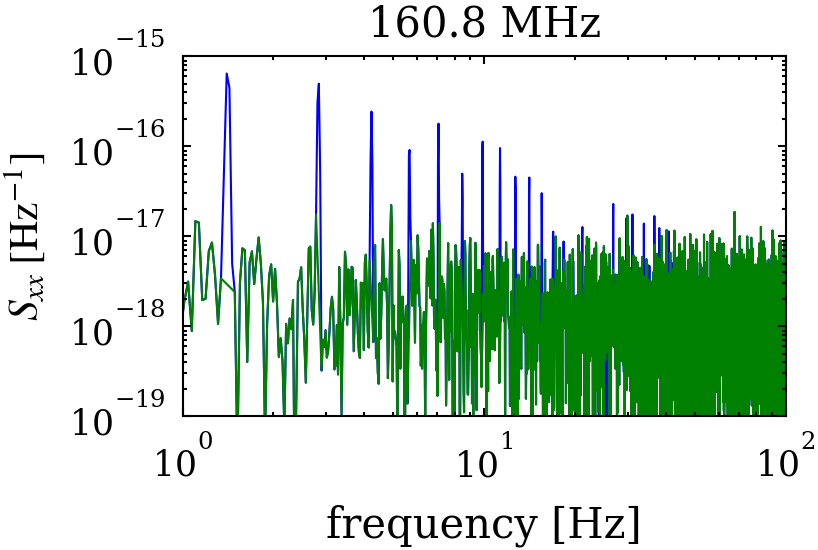

In [43]:
mask = harmonic_mask(f=ss.S_frequency, fundamental=f_ptc, num_harmonics=30, width=0.05)

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_{xx} \; [\mathrm{Hz}^{-1}]$')
ax.set_title('{:.1f} MHz'.format(1e-6 * ss.sweep.resonator.f_0))
ax.plot(ss.S_frequency, ss.S_xx)
#ax.plot(ss.S_frequency[~mask], ss.S_xx[~mask], '.r')
ax.plot(ss.S_frequency[mask], ss.S_xx[mask], 'g')
ax.set_ylim(1e-19, 1e-15)
ax.set_xlim(1, 100);

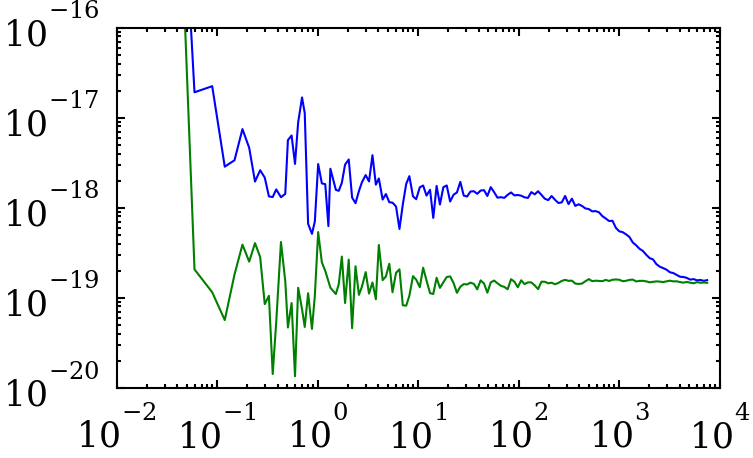

In [45]:
sss=shield[0]
sss.set_S(detrend=plt.mlab.detrend_none, window=plt.mlab.window_hanning, binned=False, NFFT=sss.stream.s21_raw.size)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
plot_log_binned_noise_after_masking_harmonics(ax, sss.S_frequency, sss.S_xx, color='blue')
plot_log_binned_noise_after_masking_harmonics(ax, sss.S_frequency, sss.S_yy, color='green')
ax.set_ylim(1e-20, 1e-16);